In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter
import control as ctl

In [2]:
df = pd.read_csv('DataBase.csv')
df.head()

,ax,ay,az,gx,gy,gz,time
0,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512,0.002044
1,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512,0.005294
2,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457,0.018674
3,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141,0.021819
4,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035,0.035171


In [3]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


dt = 0.030
df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,az,gx,gy,gz
0,0.00,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512
1,0.03,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141
2,0.06,-0.087402,-0.084961,-1.063965,-7.873535,-3.723145,-0.427246
3,0.09,-0.089355,-0.079102,-1.066895,-2.136230,-3.479004,0.488281
4,0.12,-0.104980,-0.067383,-1.048828,-0.366211,-1.586914,-0.122070


In [4]:
xData = df.time.values
yData = df.gx.values

# IMPLEMENTANDO OS FILTROS
- Filtro de Butterworth

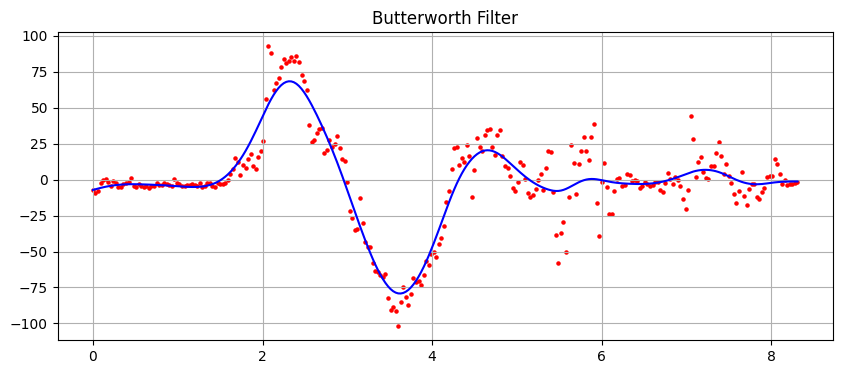

In [5]:
order = 2           # Ordem do filtro
cutoff_freq = 0.05  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButter = filtfilt(b, a, yData)

plt.figure(figsize=(10, 4))
plt.title(f'Butterworth Filter')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yButter, color='blue')
plt.grid()

- Filtro de Laplace

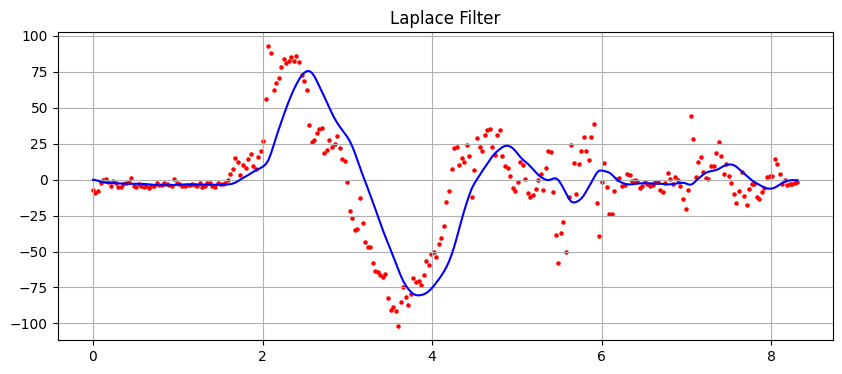

In [6]:
class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]
    

filter = LaplaceFilter(Ts=.7, UP=0.01, dt=dt)
yLaplace = np.array([filter.update(val) for val in yData])

plt.figure(figsize=(10, 4))
plt.title(f'Laplace Filter')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yLaplace, color='blue')
plt.grid()

- Filtro Gaussiano

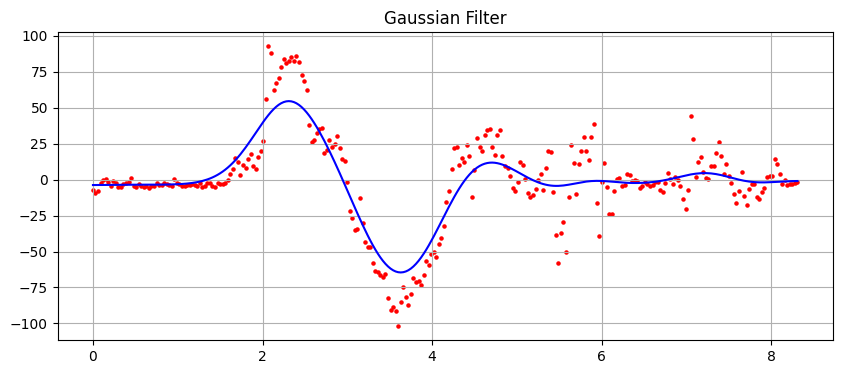

In [7]:
yGaussian = gaussian_filter(yData, sigma=10)

plt.figure(figsize=(10, 4))
plt.title(f'Gaussian Filter')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yGaussian, color='blue')
plt.grid()

# IMPLEMENTANDO FUSÃO
Antes de realizar a fusão por filtros, é preciso obter a incerteza nas medições de cada sensor e encontrar o desvio padrão, utilizando a relação $\Delta = k\,\sigma$

- Em uma Gaussiana, cerca de 68 % dos valores caem dentro de $\pm 1\sigma$ do valor médio, $k=1$
- Cerca de 95 % caem dentro de $\pm 2\sigma$, $k=2$
- Cerca de 99,7 % dentro de $\pm 3\sigma$, $k=3$

Então se um sensor de temperatura tem medida $25º \pm 5º$ ≈95% de confiança:
- $k = 2$
- $\sigma = \frac{\Delta}{k} = \frac{5}{2} = 2.5$º
- $P = \sigma^2 = 2.5² = 6.25$

# FUSÃO COVARIANCE INTERSECTION (CI)
- x1, x2: estimativas escalares (valores de entrada)
- p1, p2: variâncias (incerteza de medida)
- w: parâmetro de fusão (confiança na entrada x1) -> valores entre [0, 1] (100%)
- Retorna (xf, pf): estimativa fundida e variância fundida

In [8]:
def joinData(data1, data2, w=0.5):
    (x1, p1) = data1
    (x2, p2) = data2

    p1_inv = 1.0 / p1
    p2_inv = 1.0 / p2

    pf_inv = w * p1_inv + (1.0 - w) * p2_inv
    pf = 1.0 / pf_inv
    
    xf = pf * ( w * p1_inv * x1 + (1.0 - w) * p2_inv * x2 )
    return xf, pf

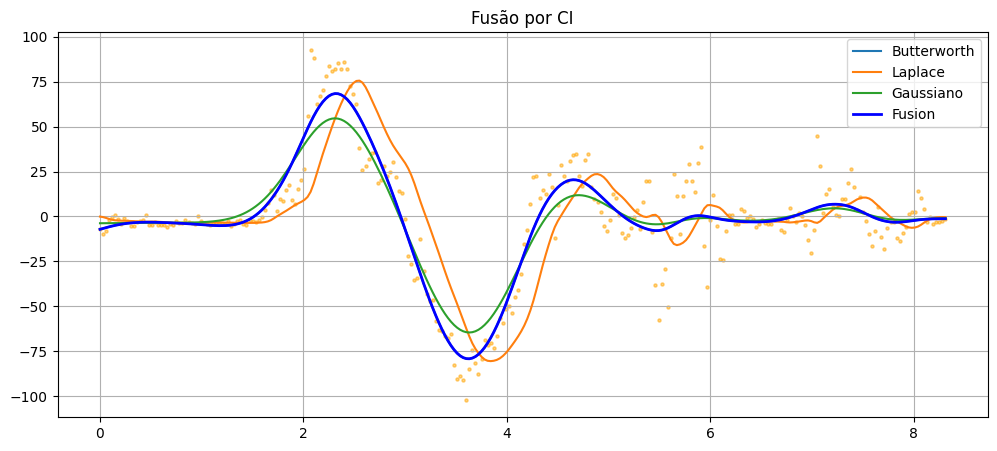

In [9]:
yModel = []

for i in range(len(yData)):
    butter   = (yButter[i],   2**2)
    laplace  = (yLaplace[i],  30**2)
    gaussian = (yGaussian[i], 50**2)
    
    response1 = joinData(butter, laplace, w=0.80)
    response2 = joinData(response1, gaussian, w=0.90)
    yModel.append(response2[0])


plt.figure(figsize=(12, 5))
plt.title('Fusão por CI')
plt.scatter(xData, yData, s=5, color='orange', alpha=0.5)
plt.plot(xData, yButter,   label='Butterworth')
plt.plot(xData, yLaplace,  label='Laplace')
plt.plot(xData, yGaussian, label='Gaussiano')
plt.plot(xData, yModel, label='Fusion', linewidth=2, color='blue')
plt.legend(), plt.grid()
plt.show()

# FUSÃO POR KALMAN

| Parâmetro | Tipo / Unidade          | Intuição prática (“tradução”)                                  | Como ajustar / escolher                                          |
|-----------|-------------------------|----------------------------------------------------------------|------------------------------------------------------------------|
| x0        | Escalar (mesma unidade) | Palpite inicial do valor real                                  | Use a 1ª leitura do sensor mais confiável ou um valor médio      |
| P0        | Escalar ≥ 0 (unidade²)  | Variância inicial → quão incerto você está sobre x0            | Grande ⇒ confia pouco no palpite; Pequeno ⇒ confia muito         |
| Q         | Escalar ≥ 0 (unidade²)  | Ruído do modelo → permite que o estado mude entre amostras      | Aumente para reagir mais rápido; diminua para suavizar           |
| R         | Matriz 3 × 3 (diag)     | Ruído de medição de cada sensor (σ² na diagonal)                | Coloque σ² de cada sensor; maior σ² ⇒ peso menor na fusão        |

In [10]:
import numpy as np

class KalmanFusion:
    def __init__(self, x0=0.0, P0=1e3, Q=1e-2, R=np.array([[1.0]])):
        self.x = float(x0)
        self.P = float(P0)
        self.Q = float(Q)
        self.R = np.atleast_2d(np.asarray(R, dtype=float))
        self.H = np.ones((self.R.shape[0], 1))

    def predict(self):
        self.P += self.Q

    def update(self, z):
        z = np.asarray(z, dtype=float).ravel()
        S = self.P * (self.H @ self.H.T) + self.R  
        invS = np.linalg.inv(S)                    
        K = (self.P * (self.H.T @ invS)).ravel()   

        y = z - (self.H[:, 0] * self.x)   
        self.x += K.dot(y)

        self.P *= (1.0 - float(K.dot(self.H[:, 0])))
        return self.x
    

x0 = yData[0]
P0 = 5**2
Q = 0.1
R = np.diag([2**2, 5**2, 10**2])  
kalman = KalmanFusion(x0, P0, Q, R)

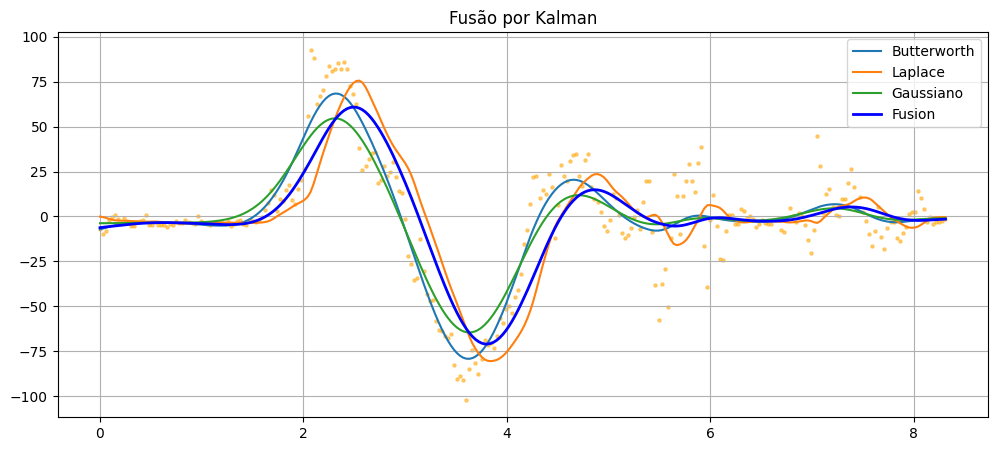

In [11]:
yModel = []

for i in range(len(xData)):
    data = np.array([yButter[i], yLaplace[i], yGaussian[i]])
    kalman.predict()
    output = kalman.update(data)
    yModel.append(output)


plt.figure(figsize=(12, 5))
plt.title('Fusão por Kalman')
plt.scatter(xData, yData, s=5, color='orange', alpha=0.5)
plt.plot(xData, yButter,   label='Butterworth')
plt.plot(xData, yLaplace,  label='Laplace')
plt.plot(xData, yGaussian, label='Gaussiano')
plt.plot(xData, yModel, label='Fusion', linewidth=2, color='blue')
plt.legend(), plt.grid()
plt.show()
